***
# Base Bi-LSTM Model<br>
***

***
## 1 Load the train/val/test/balanced test datasets
emotions_with_neutrals_220228.csv concatenated the neutrals from Kaggle dataset<br>
https://github.com/dair-ai/emotion_dataset<br>
https://huggingface.co/datasets/dair-ai/emotion<br>

In [ ]:
import pandas as pd
import numpy as np

# mount google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# read from the google drive
project_folder = '/content/gdrive/MyDrive/266_Final_Project_Folder'

train_source = project_folder + '/datasets/train_data_imbalanced_stratified_no_dupe.csv'
test_source = project_folder + '/datasets/test_data_imbalanced_stratified_no_dupe.csv'
val_source = project_folder + '/datasets/validation_data_imbalanced_stratified_no_dupe.csv'
balanced_test_source = project_folder + '/datasets/test_data_balanced_no_dupe.csv'

# Load the dfs
train_df = pd.read_csv(train_source)
test_df = pd.read_csv(test_source)
val_df = pd.read_csv(val_source)
balanced_test_df = pd.read_csv(balanced_test_source)

# drop the tweet_id column
train_df.drop(columns=train_df.columns[0], axis=1, inplace=True)
test_df.drop(columns=test_df.columns[0], axis=1, inplace=True)
val_df.drop(columns=val_df.columns[0], axis=1, inplace=True)
balanced_test_df.drop(columns=balanced_test_df.columns[0], axis=1, inplace=True)

### Confirm no overlapping records 

In [ ]:
# Check if there are any records in train_df that are in val_df
overlap = train_df['text'].isin(val_df['text'])
print(f"Number of overlapping records, train-val: {overlap.sum()}")

# Check if there are any records in val_df that are in train_df
overlap = val_df['text'].isin(train_df['text'])
print(f"Number of overlapping records, val-train: {overlap.sum()}")


# Check if there are any records in train_df that are in test_df
overlap = train_df['text'].isin(test_df['text'])
print(f"Number of overlapping records, train-test: {overlap.sum()}")

# Check if there are any records in test_df that are in train_df
overlap = test_df['text'].isin(train_df['text'])
print(f"Number of overlapping records, test-train: {overlap.sum()}")


# Check if there are any records in train_df that are in balanced_test_df
overlap = train_df['text'].isin(balanced_test_df['text'])
print(f"Number of overlapping records, train-balanced test: {overlap.sum()}")

# Check if there are any records in train_df that are in balanced_test_df
overlap = balanced_test_df['text'].isin(train_df['text'])
print(f"Number of overlapping records, balanced test, train: {overlap.sum()}")

Number of overlapping records, train-val: 0
Number of overlapping records, val-train: 0
Number of overlapping records, train-test: 0
Number of overlapping records, test-train: 0
Number of overlapping records, train-balanced test: 0
Number of overlapping records, balanced test, train: 0


In [ ]:
train_df

,text,emotions
0,ive been feeling rather jealous,anger
1,ive officially started to feel uncomfortable,fear
2,im acting like the rotten person i am who feel...,sadness
3,i feel a mournful grasp,sadness
4,i started to feel smug,joy
...,...,...
256227,i don t get that one feeling anymore just curi...,surprise
256228,i was feeling a little unhappy in almost all a...,sadness
256229,i was there and soon to be berlin feeling gloo...,sadness
256230,im feeling a little too violent and my mother ...,anger


In [ ]:
test_df

,text,emotions
0,i feel impatient to get moving forward,anger
1,i have decided to open wb to a few thoughtful ...,joy
2,i resolved at that moment to do my bit when i ...,sadness
3,i like his tip especially if you need assistan...,joy
4,i feel that if he did not want to be on the sh...,joy
...,...,...
37956,i am serving alongside other leaders in the de...,fear
37957,i am a little tipsy and feeling quite fond of ...,love
37958,i made my way to the front of the stage feelin...,fear
37959,i feel like nicholas is a really smart guy and...,joy


In [ ]:
val_df

,text,emotions
0,im starting to feel a lot less terrified of her,fear
1,i can t appease everyone my lives are mainly i...,sadness
2,i feel for him is so valuable absolute and rar...,joy
3,i am friendly and so easy to talk to if only y...,fear
4,i came into the game feeling a bit lonely and ...,sadness
...,...,...
85406,i miss feeling insulted or feeling discouraged...,anger
85407,i feel like they liked my rough draft,love
85408,i just need to adjust my mindset to feel pleas...,joy
85409,id be working a max of hours if theyre feeling...,joy


In [ ]:
balanced_test_df

,text,emotions
0,i will get at the heart of the matter that you...,anger
1,i still feel selfish about it at times,anger
2,i feel a sarcastic emptyness and void in my life,anger
3,overeating a traditional type of food blood pu...,anger
4,i just have this feeling that im going to be b...,anger
...,...,...
6015,i am giving myself permission to feel funny aga,surprise
6016,i feel shocked angry confused,surprise
6017,im writing this blog post and feeling totally ...,surprise
6018,i feel this for all my grandchildren and with ...,surprise


***
## 2 Tokenizer

### Find the top word count (frequency > 10)
We'll use this number as our vocabulary size

In [ ]:
# Split the text column into a list of words
words_df = train_df['text'].str.split().to_frame('words')

# Explode the list of words into separate rows
words_df = words_df.explode('words')

# Group by the words and count their occurrences
words_df = words_df.groupby('words').size().reset_index(name='count')
words_df

,words,count
0,!,43
1,!!,9
2,!!!,3
3,!!!!,1
4,!!!!!!!!!!!!,1
...,...,...
73765,ï¿½o_0ï¿½*giggles*ï¿½who,1
73766,ï¿½tearï¿½,1
73767,ï¿½ureo,1
73768,ï¿½why?,1


In [ ]:
# find the words with 'count' > 10
condition = words_df['count'] > 10

# sort the words based on count
new_words_df = words_df[condition].sort_values('count', ascending=False)
new_words_df

,words,count
35522,i,406035
28222,feel,173555
10149,and,150667
66570,to,140963
65637,the,131883
...,...,...
66925,tore,11
24444,doula,11
11821,autonomy,11
48630,operations,11


In [ ]:
# how many words are > 10?
top_word_count = len(new_words_df)
print('Vocabulary size:', top_word_count)

Vocabulary size: 11039


### Let's tokenize the train tweets!

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=top_word_count, oov_token='<UNK>')
tokenizer.fit_on_texts(train_df['text']) # pass in tweets from training set

In [ ]:
# this is what the tweet looks like as words
train_df['text'][0]

'ive been feeling rather jealous'

In [ ]:
# this is what the tokenized version of the tweet looks like
tokenizer.texts_to_sequences([train_df['text'][0]])

[[74, 47, 8, 194, 427]]

(array([2.7100e+02, 8.3600e+02, 4.9050e+03, 1.7587e+04, 1.0099e+04,
        9.9730e+03, 1.0327e+04, 2.0549e+04, 1.0492e+04, 1.0265e+04,
        1.0004e+04, 1.9662e+04, 9.2690e+03, 9.1240e+03, 8.4760e+03,
        1.5868e+04, 7.4850e+03, 6.7480e+03, 1.2427e+04, 5.6720e+03,
        5.1510e+03, 4.7190e+03, 8.3660e+03, 3.5790e+03, 3.2520e+03,
        3.0450e+03, 5.3200e+03, 2.3020e+03, 2.0350e+03, 1.8770e+03,
        3.2480e+03, 1.4790e+03, 1.3510e+03, 2.2750e+03, 9.8900e+02,
        9.3000e+02, 8.1000e+02, 1.3820e+03, 5.7900e+02, 5.5500e+02,
        5.3000e+02, 8.3000e+02, 3.5300e+02, 3.0100e+02, 2.3900e+02,
        3.1500e+02, 1.0900e+02, 8.1000e+01, 1.0200e+02, 2.8000e+01,
        1.8000e+01, 1.4000e+01, 1.2000e+01, 5.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

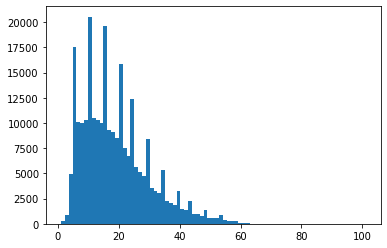

In [ ]:
import matplotlib.pyplot as plt

# check to see what lenghts of the tweets in the dataset
lengths = [len(t.split(' ')) for t in train_df['text']]
plt.hist(lengths, bins=len(set(lengths)))

In [ ]:
import statistics

# Apply the lambda function to the 'content' column and list called word_count_list'
word_count_list = list(train_df['text'].apply(lambda x: len(x.split(' '))))

# display the maximum and minimum lengths
print('Maximum word count:', max(word_count_list))
print('Minimum word count:', min(word_count_list))
print('Mean word count:', statistics.mean(word_count_list))
print('Median word count:', statistics.median(word_count_list))
print('75th percentile word count:', np.percentile(word_count_list, 75))
print('85th percentile word count:', np.percentile(word_count_list, 85))
print('95th percentile word count:', np.percentile(word_count_list, 95))

Maximum word count: 101
Minimum word count: 1
Mean word count: 18.995761653501514
Median word count: 17.0
75th percentile word count: 25.0
85th percentile word count: 30.0
95th percentile word count: 41.0


The max number of words is 101. We ultimately decided that we are going to keep all the words in the tweet. BERT can handle more than 200 so setting max_len = 200

***
## 3 Padding and truncating the training data sequences to make sure that the shape is the same for each string.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
max_len = 200 # set the largest tweet size, >200 words -> truncate, <200 words -> pad

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len) # truncating happens at the end of the sequence (post)
  return padded # all examples will be the returned with same input size

In [ ]:
padded_train_seq = get_sequences(tokenizer, train_df['text'])
padded_train_seq[0]

array([ 74,  47,   8, 194, 427,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

***
## 4 Convert labels to numeric

### Function to convert text labels to numeric (reuse for all datasets)

In [ ]:
# keeping this consistent for all models
class_to_index_dict = {'sadness': 0, 'anger': 1, 'fear': 2, 'surprise': 3, 'joy': 4, 'love': 5, 'neutral': 6}
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [ ]:
def names_to_ids(class_to_index, data):
  return np.array([class_to_index.get(x) for x in data])

In [ ]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
train_labels = names_to_ids(class_to_index_dict, train_df['emotions'])
print('train_df.iloc[7]:\n', train_df.iloc[index])
print('numeric label:', train_labels[index])

train_df.iloc[7]:
 text        i do think that with a heartfelt discussion my...
emotions                                                 fear
Name: 7, dtype: object
numeric label: 2


***
## 5 Create the model

In [ ]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.11.0


In [ ]:
# ref: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
# ref: https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# ref: https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=top_word_count, output_dim=8, input_length=max_len),
    
    # the RNN part of the model
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)), # since using an LSTM layer inside a bidrectional layer, context can go in either direction; return_sequences=True means at every time step, there is an output
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, )),

    tf.keras.layers.Dense(7, activation='softmax') # 7 for the seven classes

])

model.compile(
    loss='sparse_categorical_crossentropy', # since this is a multiclass classification problem, use categorical crossentropy; since classes are integers (not one hot encoded/binary), use sparse (just like in A3)
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 8)            88312     
                                                                 
 bidirectional (Bidirectiona  (None, 20)               1520      
 l)                                                              
                                                                 
 dense (Dense)               (None, 7)                 147       
                                                                 
Total params: 89,979
Trainable params: 89,979
Non-trainable params: 0
_________________________________________________________________


***
## 6 Train the model

### Convert the labels of the validation set to numeric (just like the training set)

In [ ]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [ ]:
val_seq = get_sequences(tokenizer, val_df['text'])
val_labels = names_to_ids(class_to_index_dict, val_df['emotions'])

In [ ]:
# checking out the first input in validation sequence
val_seq[0], val_df['text'][0], val_df['emotions'][0]

(array([ 17, 306,   5,   3,   7, 160, 170, 486,  10,  68,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [ ]:
print('val_df.iloc[0]:\n', val_df.iloc[0])
print('numeric label:', val_labels[0])

val_df.iloc[0]:
 text        im starting to feel a lot less terrified of her
emotions                                               fear
Name: 0, dtype: object
numeric label: 2


#### Check out the shape to make sure they're as expected

In [ ]:
padded_train_seq.shape

(256232, 200)

In [ ]:
train_labels.shape

(256232,)

In [ ]:
val_seq.shape

(85411, 200)

In [ ]:
val_labels.shape

(85411,)

### From Natalie's Notebook
https://github.com/datasci-w266/2023-spring-main/blob/master/materials/walkthrough_notebooks/keras_with_limited_ram/keras_training_with_limited_ram.ipynb<br><br>
https://edstem.org/us/courses/32607/discussion/2699088?comment=6229916

#### Inspired by Natalie's notebook, made my own generator that chunks up my data into pieces that won't make my machine run out of memory before completing one epoch
If generator is not used, might delete this section

In [ ]:
# from sklearn.utils.random import sample_without_replacement

# # Define a generator function
# def generator(data, labels, batch_size):
#     # num_samples = len(data)
#     # while True:
#     #     indices = np.random.randint(num_samples, size=batch_size)
#     #     yield data[indices], labels[indices]

#     # Loop over batches
#     for i in range(0, len(data), batch_size):
      
#       # Get a batch of indices using sample_without_replacement()
#       batch_indices = sample_without_replacement(n_population=len(data), n_samples=batch_size)
      
#       # Yield a batch of features and labels using the indices
#       yield data[batch_indices], labels[batch_indices]

In [ ]:
# Create the generator
# batch_size = 1 # using this batch size because that's what seemed reasonable based on the number of records in the training dataset
# gen = generator(data=padded_train_seq, labels=train_labels, batch_size=batch_size)

#### Setting up checkpoints

In [ ]:
# reference: https://pynative.com/python-timezone/
# make a timestamp so it can be part of the folder name
# otherwise, all the checkpoints get dumped into the same
# folder and that's not great
import datetime
import pytz

local_tz = pytz.timezone('America/Denver')
local_dt = datetime.datetime.now(local_tz)

# Format the datetime object as a string without spaces
timestamp = local_dt.strftime('/%Y-%m-%d-%H%M')

# Print the string
print(timestamp)

/2023-03-09-1950


In [ ]:
!ls '/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/'

archive


In [ ]:
checkpoint_dir = project_folder + '/cm_working_dir/cm_checkpoints'
checkpoint_filepath = checkpoint_dir + '/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5' #+ timestamp + '/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [ ]:
# check to make sure that the folder name is as expected
# format: .....cm_checkpoints/YYYY-MM-DD-TIME/....
print(checkpoint_filepath)

/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5


### Training the Model!!!

##### Uncomment cell below to load checkpoints; else keep commented to start fresh

In [ ]:
# uncomment below when loading checkpoints
# hdf5_checkpoint = 'weights.05-0.99' # change this to the right filename for the checkpoint
# checkpoint_filepath = checkpoint_dir + '/' + hdf5_checkpoint + '.hdf5'
# model.load_weights(checkpoint_filepath)

In [ ]:
# batch_size = 64
# steps_per_epoch = len(padded_train_seq) / batch_size

# history = model.fit(
#     gen,
#     validation_data=(val_seq, val_labels),
#     steps_per_epoch=steps_per_epoch,
#     epochs=1,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
#         model_checkpoint_callback
#     ]
# )

##### Training a fresh model (don't run this if running cells above)

In [ ]:
batch_size = 64
steps_per_epoch = len(padded_train_seq) / batch_size

history = model.fit(
    # gen,
    padded_train_seq,
    train_labels,
    validation_data=(val_seq, val_labels),
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
        model_checkpoint_callback
    ]
)

Epoch 1/5
4003/4003 [==============================] - 509s 126ms/step - loss: 0.6618 - accuracy: 0.7661 - val_loss: 0.2498 - val_accuracy: 0.9284
Epoch 2/5
4003/4003 [==============================] - 523s 131ms/step - loss: 0.1564 - accuracy: 0.9578 - val_loss: 0.1027 - val_accuracy: 0.9699
Epoch 3/5
4003/4003 [==============================] - 535s 134ms/step - loss: 0.0797 - accuracy: 0.9764 - val_loss: 0.0794 - val_accuracy: 0.9758
Epoch 4/5
4003/4003 [==============================] - 544s 136ms/step - loss: 0.0566 - accuracy: 0.9830 - val_loss: 0.0715 - val_accuracy: 0.9782
Epoch 5/5
4003/4003 [==============================] - 547s 137ms/step - loss: 0.0439 - accuracy: 0.9867 - val_loss: 0.0664 - val_accuracy: 0.9799


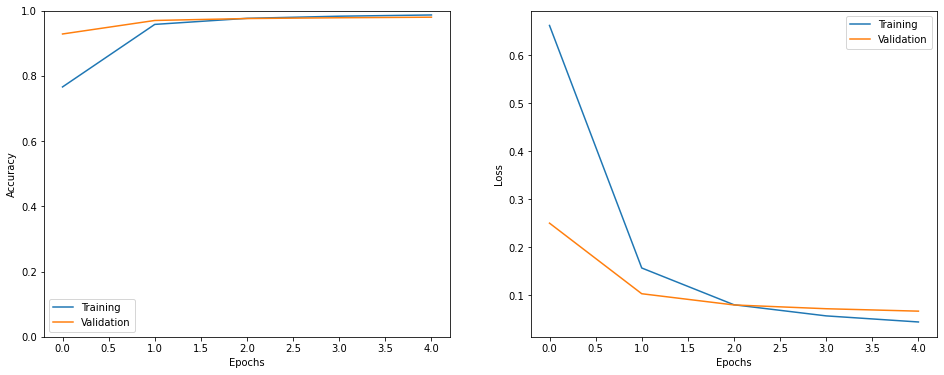

In [ ]:
show_history(history)

***
## 7 Evaluate the model using imbalanced test_df

In [ ]:
# borrowing this from A3 assignment, but turned it into a function
# classification report (cr) and confusion matrix (cm) from A3
from sklearn.metrics import classification_report
import seaborn as sns

def make_cr_cm(preds, labels):

  predictions_model = tf.argmax(preds, axis=-1)
  predictions_model

  # convert labels to string because classification_report needs target_names as str
  # labels are currently ints, but will change to str of in (i.e. '0', '1', etc)
  class_names = list(set([str(digit) for digit in labels]))

  # convert digits in target_names to the actual name of the emotion from the 
  # using class_to_index dictionary (i.e. '0' -> 'love', '5' -> 'neutral', etc.)
  class_names = [list(class_to_index_dict.keys())[list(class_to_index_dict.values()).index(int(name))] for name in class_names]

  print('Classification Report:\n\n', classification_report(labels, predictions_model.numpy(), target_names=class_names))

  print('Confusion Matrix:\n')
  
  # confusion matrix from A3
  cm = tf.math.confusion_matrix(labels, predictions_model)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(20,7))
  sns.heatmap(
      cm, annot=True,
      xticklabels=class_names,
      yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

### Padding the imbalanced test set for evaluation

In [ ]:
padded_test_seq = get_sequences(tokenizer, test_df['text'])
padded_test_seq[0]

array([  2,   3, 537,   5,  54, 885, 754,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [ ]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
test_labels = names_to_ids(class_to_index_dict, test_df['emotions'])
print('test_df.iloc[7]:\n', test_df.iloc[index])
print('numeric label:', test_labels[index])

test_df.iloc[7]:
 text        i never orgasm the feeling is lovely
emotions                                    love
Name: 7, dtype: object
numeric label: 5


### Evaluating the model using test_df!!!

In [ ]:
model.evaluate(padded_test_seq, test_labels)

1187/1187 [==============================] - 27s 22ms/step - loss: 0.0667 - accuracy: 0.9796


[0.0667484700679779, 0.9795843362808228]

In [ ]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_df.iloc[i])
print('Emotion:', test_labels[i])

p = model.predict(np.expand_dims(padded_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        i can seemingly move from one to the other wit...
emotions                                                 love
Name: 10291, dtype: object
Emotion: 5
1/1 [==============================] - 1s 1s/step
Predicted Emotion: 5


In [ ]:
preds_imbalanced_test_set = model.predict(padded_test_seq)

1187/1187 [==============================] - 26s 22ms/step


Classification Report:

               precision    recall  f1-score   support

     neutral       0.99      0.99      0.99     11587
        love       0.98      0.96      0.97      5226
        fear       0.97      0.97      0.97      3955
         joy       0.96      0.97      0.97       982
    surprise       0.98      0.98      0.98     12917
       anger       0.97      0.98      0.98      2434
     sadness       0.91      0.97      0.94       860

    accuracy                           0.98     37961
   macro avg       0.97      0.98      0.97     37961
weighted avg       0.98      0.98      0.98     37961

Confusion Matrix:



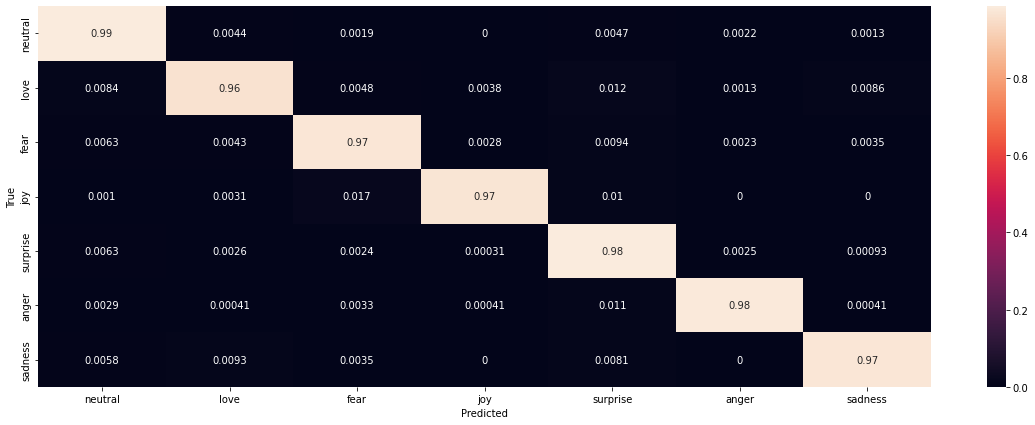

In [ ]:
make_cr_cm(preds_imbalanced_test_set, test_labels)

***
## 8 Evaluating the model again, but with balanced_test_df!!!

### Padding the balanced test set for evaluation

In [ ]:
padded_balanced_test_seq = get_sequences(tokenizer, balanced_test_df['text'])
padded_balanced_test_seq[0]

array([   2,   57,   54,   33,    6,  233,   10,    6,  507,    9,   31,
        114,   31,   69,   25,    4,    3,   60,    6,  233,    9, 1084,
         31,   36,  141,  731,    6, 2215,   10,  121, 7038,   10,  107,
         31,  796, 1263,   19,    7, 1046,  881,    1, 2250,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [ ]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
balanced_test_labels = names_to_ids(class_to_index_dict, balanced_test_df['emotions'])
print('balanced_test_df.iloc[7]:\n', balanced_test_df.iloc[index])
print('numeric label:', balanced_test_labels[index])

balanced_test_df.iloc[7]:
 text        i feel like i m wronged
emotions                      anger
Name: 7, dtype: object
numeric label: 1


### Evaluating the model using balanced_test_df!!!

In [ ]:
model.evaluate(padded_balanced_test_seq, balanced_test_labels)

189/189 [==============================] - 5s 26ms/step - loss: 0.0876 - accuracy: 0.9739


[0.08757195621728897, 0.9739202857017517]

In [ ]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(balanced_test_labels) - 1)

print('Sentence:', balanced_test_df.iloc[i])
print('Emotion:', balanced_test_labels[i])

p = model.predict(np.expand_dims(padded_balanced_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        fear came towards the end of may when the pts ...
emotions                                                 fear
Name: 914, dtype: object
Emotion: 2
1/1 [==============================] - 0s 37ms/step
Predicted Emotion: 2


In [ ]:
preds_balanced_test_set = model.predict(padded_balanced_test_seq)

189/189 [==============================] - 4s 21ms/step


Classification Report:

               precision    recall  f1-score   support

     neutral       0.96      0.99      0.98       860
        love       0.98      0.96      0.97       860
     sadness       0.96      0.97      0.96       860
        fear       0.99      0.96      0.98       860
    surprise       0.94      0.99      0.96       860
       anger       0.99      0.98      0.99       860
         joy       0.99      0.97      0.98       860

    accuracy                           0.97      6020
   macro avg       0.97      0.97      0.97      6020
weighted avg       0.97      0.97      0.97      6020

Confusion Matrix:



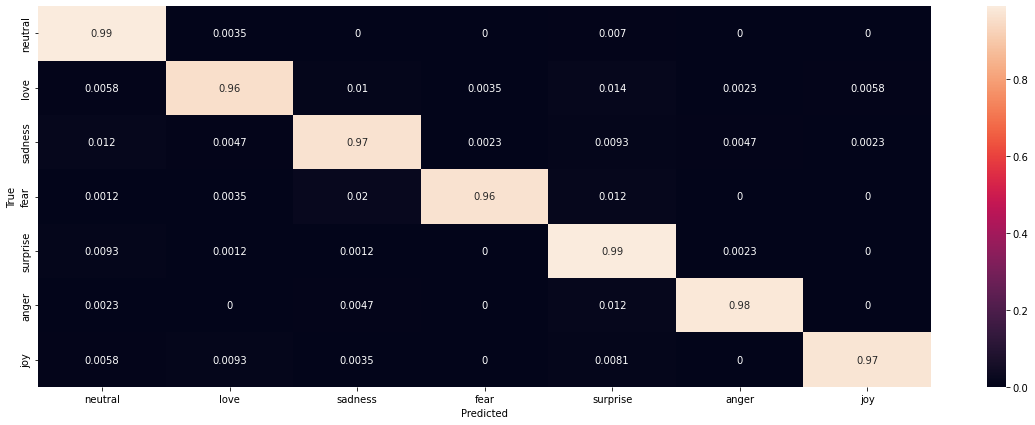

In [ ]:
make_cr_cm(preds_balanced_test_set, balanced_test_labels)

# Code Graveyard
This will probably be deleted later

In [ ]:
# # classification report from A3

# predictions_model2 = tf.argmax(preds2, axis=-1)
# predictions_model2

# target_names2 = list(set([str(digit) for digit in balanced_test_labels]))

# print(classification_report(balanced_test_labels, predictions_model2.numpy(), target_names=target_names2))

In [ ]:
# # confusion matrix from A3
# cm = tf.math.confusion_matrix(balanced_test_labels, predictions_model2)
# cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

# plt.figure(figsize=(20,7))
# sns.heatmap(
#     cm, annot=True,
#     xticklabels=target_names2,
#     yticklabels=target_names2)
# plt.xlabel("Predicted")
# plt.ylabel("True")

In [ ]:
# import seaborn as sns

# # confusion matrix from A3
# cm = tf.math.confusion_matrix(test_labels, predictions_model1)
# cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

# plt.figure(figsize=(20,7))
# sns.heatmap(
#     cm, annot=True,
#     xticklabels=target_names,
#     yticklabels=target_names)
# plt.xlabel("Predicted")
# plt.ylabel("True")

In [ ]:
# classification report from A3
# from sklearn.metrics import classification_report

# predictions_model1 = tf.argmax(preds, axis=-1)
# predictions_model1

# target_names = list(set([str(digit) for digit in test_labels]))

# print(classification_report(test_labels, predictions_model1.numpy(), target_names=target_names))